In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import shutil
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
test_base_dir ="/kaggle/input/gtsrb-german-traffic-sign"

# File paths for CSV files

test_csv_path = '/kaggle/input/gtsrb-german-traffic-sign/Test.csv'

# Load CSV files
test_df = pd.read_csv(test_csv_path)

# Load CSV files
test_df = pd.read_csv(test_csv_path)

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Concatenate base directory with relative image path
        img_path = os.path.join(self.base_dir, str(self.dataframe.iloc[idx, -1]))
        label = int(self.dataframe.iloc[idx, -2])  # Ensure this is the correct column for labels
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise ValueError(f"Image not found: {img_path}")
        if self.transform:
            image = self.transform(image)
        return image, label


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create Datasets
test_dataset = CustomDataset(test_df, test_base_dir, transform=test_transforms)

# Create Data Loaders
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
print(f"Total images in test dataset: {len(test_dataset)}")

Total images in test dataset: 12630


In [10]:
# Load the trained model
model_path = "/kaggle/input/theiss_model/pytorch/default/1/mobilenet_v2_traffic_signs.pth"  # Replace with the path to your saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reconstruct the model architecture
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.last_channel, 43)  # 43 classes in your dataset
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

<ipython-input-10-29859e955a0a>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
def test_model(model, test_loader, device):
    """
    Test the model and return accuracy, labels, and predictions.

    Args:
        model (torch.nn.Module): The model to test.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): The device to perform testing on (CPU or GPU).

    Returns:
        tuple: A tuple containing accuracy, all true labels, and all predicted labels.
    """
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Collect all labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    return accuracy, all_labels, all_predictions


In [12]:
ccuracy, all_labels, all_predictions = test_model(model, test_loader, device)

Testing: 100%|██████████| 12630/12630 [04:06<00:00, 51.28it/s]

Test Accuracy: 95.61%


In [13]:
def predict(model, image, device):
    image = image.to(device)

    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = probabilities.max(1)

    result = {
        "predicted_class": predicted.item(),
        "confidence": confidence.item()
    }

    return result

In [14]:
image_path = "/kaggle/input/gtsrb-german-traffic-sign/Test/00000.png"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = transform(image)

# Perform prediction
result = predict(model, image_tensor, device)

# Print the result
print("predicted_class:", result["predicted_class"])
print("confidence:", result["confidence"])

predicted_class: 16
confidence: 1.0


In [15]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_and_save_confusion_matrix(all_labels, all_predictions, filename="confusion_matrix.csv"):
    """
    Plot and save the confusion matrix using true and predicted labels.

    Args:
        all_labels (list): True labels.
        all_predictions (list): Predicted labels.
        filename (str): Filename to save the confusion matrix.
    """
    class_names = [str(i) for i in range(43)]  # Generate class names from 0 to 42
    cm = confusion_matrix(all_labels, all_predictions)

    # Save confusion matrix to CSV
    pd.DataFrame(cm).to_csv(filename, index=False, header=False)
    print(f"Confusion matrix saved as {filename}")

    # Plotting the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.tight_layout()
    plt.show()


Confusion matrix saved as confusion_matrix.csv


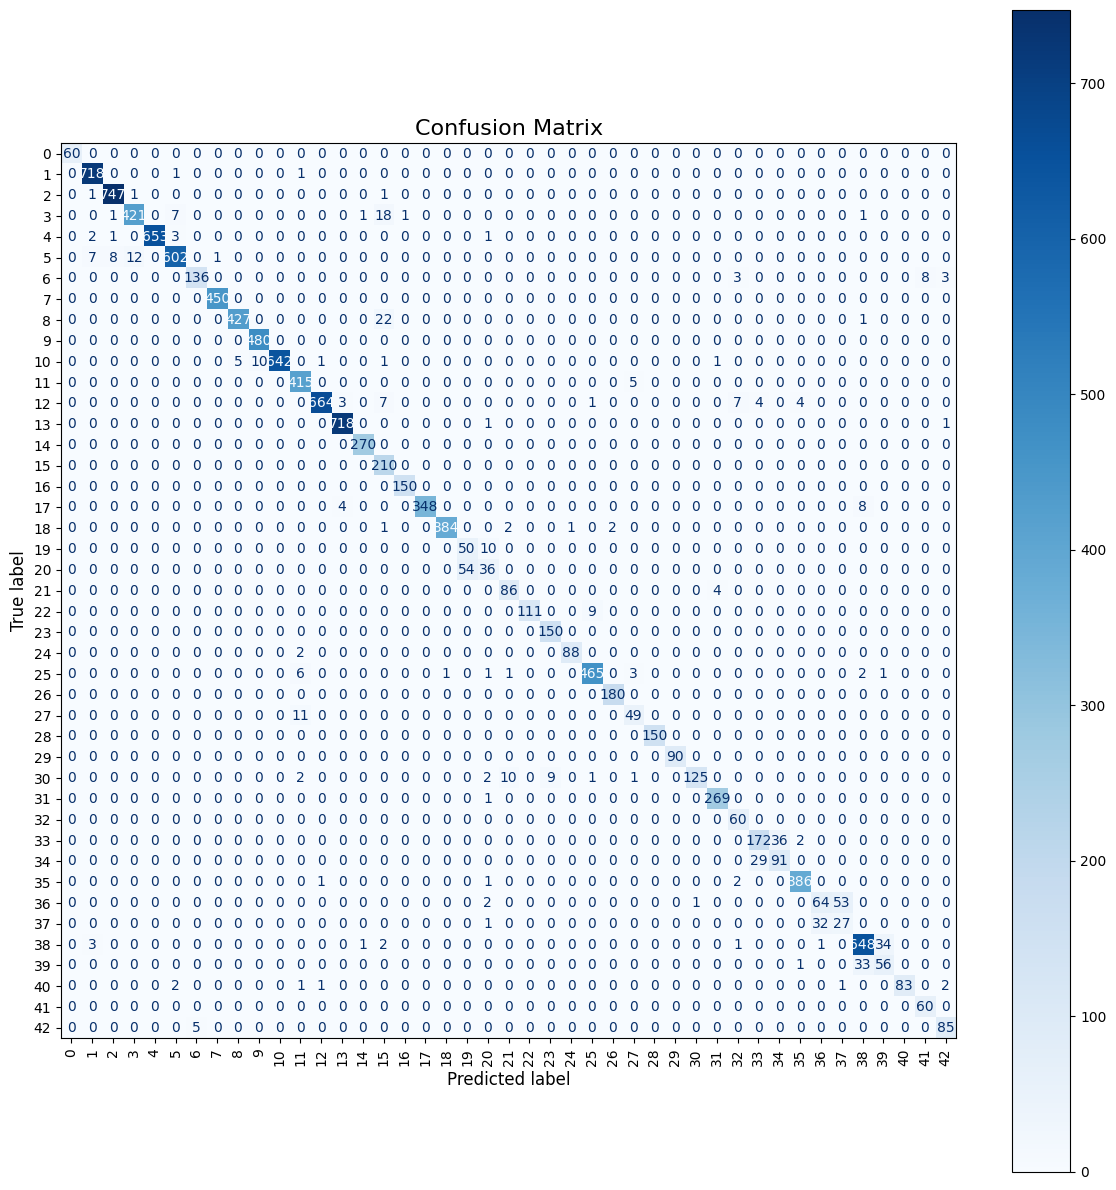

In [16]:
plot_and_save_confusion_matrix(all_labels, all_predictions)

In [17]:
def plot_roc_curve(model, test_loader, device, num_classes=43):
    """
    Plot the ROC curve for a multi-class classification model.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): The device to perform testing on (CPU or GPU).
        num_classes (int): The number of classes in the dataset.
    """
    model.eval()
    all_labels = []
    all_outputs = []

    # Collect predictions and true labels
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Calculating ROC"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        true_binary = (all_labels == i).astype(int)  # Convert labels to binary for each class
        fpr[i], tpr[i], _ = roc_curve(true_binary, all_outputs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    # Plot the diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

    plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()


Calculating ROC: 100%|██████████| 12630/12630 [02:21<00:00, 89.07it/s] 


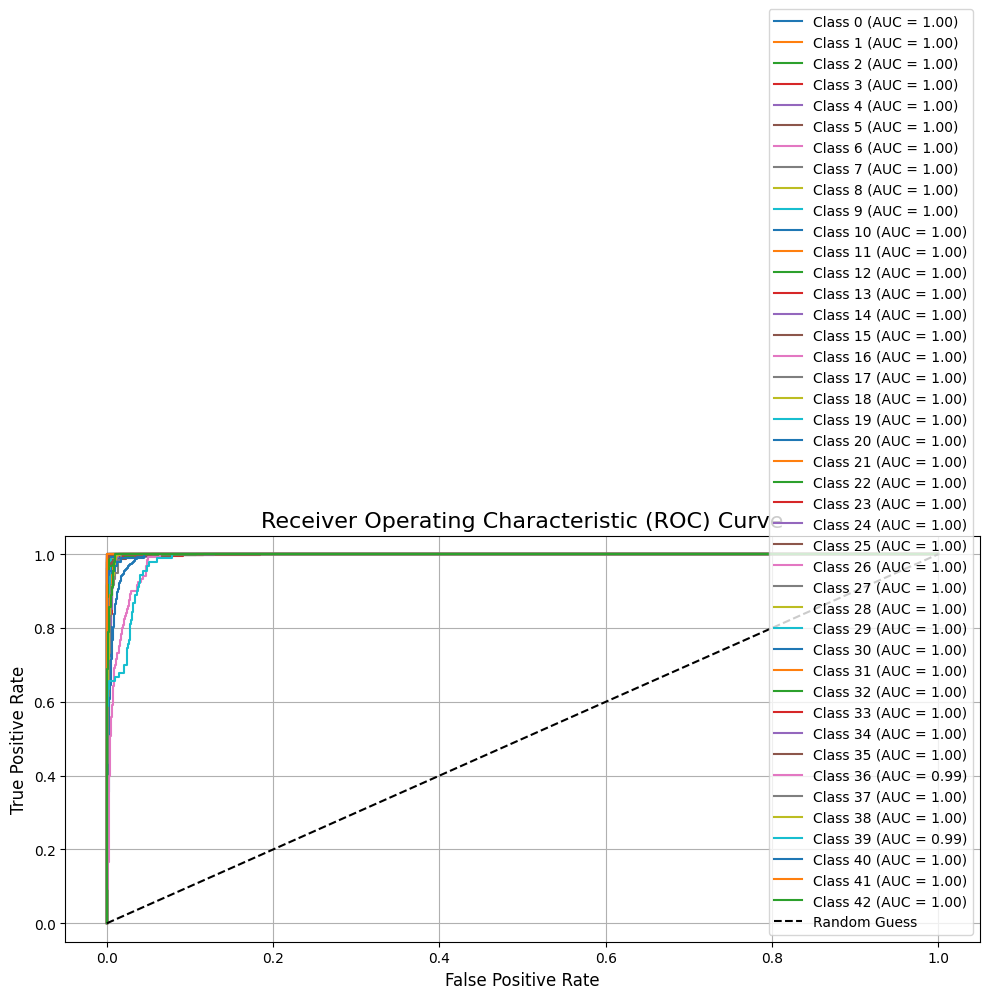

In [18]:
plot_roc_curve(model, test_loader, device, num_classes=43)

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

def plot_precision_recall_curve(model, test_loader, device, num_classes=43):
    """
    Plot the Precision-Recall curve for a multi-class classification model.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): The device to perform testing on (CPU or GPU).
        num_classes (int): The number of classes in the dataset.
    """
    model.eval()
    all_labels = []
    all_outputs = []

    # Collect predictions and true labels
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Calculating Precision-Recall"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)

    # Compute Precision-Recall curve and Average Precision for each class
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(num_classes):
        true_binary = (all_labels == i).astype(int)  # Convert labels to binary for each class
        precision[i], recall[i], _ = precision_recall_curve(true_binary, all_outputs[:, i])
        average_precision[i] = average_precision_score(true_binary, all_outputs[:, i])

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], label=f"Class {i} (AP = {average_precision[i]:.2f})")

    plt.title("Precision-Recall Curve", fontsize=16)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.legend(loc="lower left", fontsize=10, ncol=2)
    plt.grid()
    plt.tight_layout()
    plt.show()


Calculating Precision-Recall: 100%|██████████| 12630/12630 [02:15<00:00, 93.00it/s] 


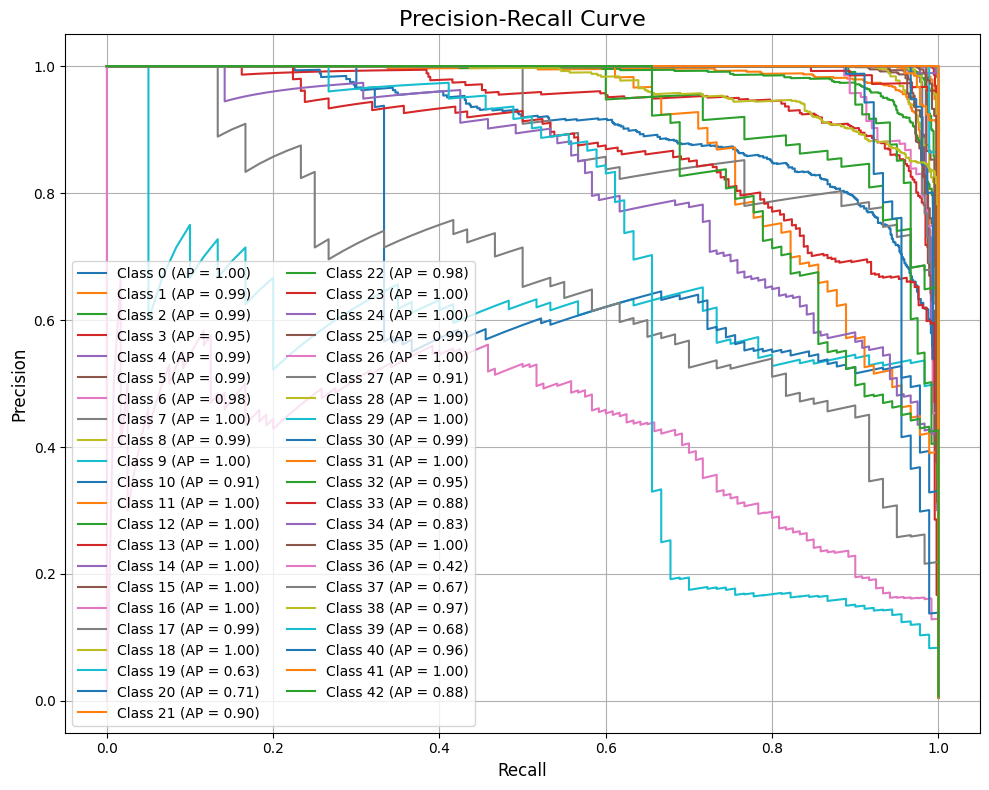

In [20]:
plot_precision_recall_curve(model, test_loader, device, num_classes=43)

In [21]:
def plot_prediction_confidence(model, test_loader, device, num_bins=10):
    """
    Plot a histogram of prediction confidence for the test dataset.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to perform testing on (CPU or GPU).
        num_bins (int): Number of bins for the histogram.
    """
    model.eval()
    confidences = []
    correct_predictions = []
    incorrect_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Calculating Confidence"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_confidence, predicted = probabilities.max(1)
            
            confidences.extend(max_confidence.cpu().numpy())
            correct_predictions.extend(max_confidence[labels == predicted].cpu().numpy())
            incorrect_predictions.extend(max_confidence[labels != predicted].cpu().numpy())

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(confidences, bins=num_bins, alpha=0.7, label="All Predictions", color="blue")
    plt.hist(correct_predictions, bins=num_bins, alpha=0.7, label="Correct Predictions", color="green")
    plt.hist(incorrect_predictions, bins=num_bins, alpha=0.7, label="Incorrect Predictions", color="red")
    plt.title("Histogram of Prediction Confidence", fontsize=16)
    plt.xlabel("Confidence", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Calculating Confidence: 100%|██████████| 12630/12630 [02:19<00:00, 90.33it/s] 


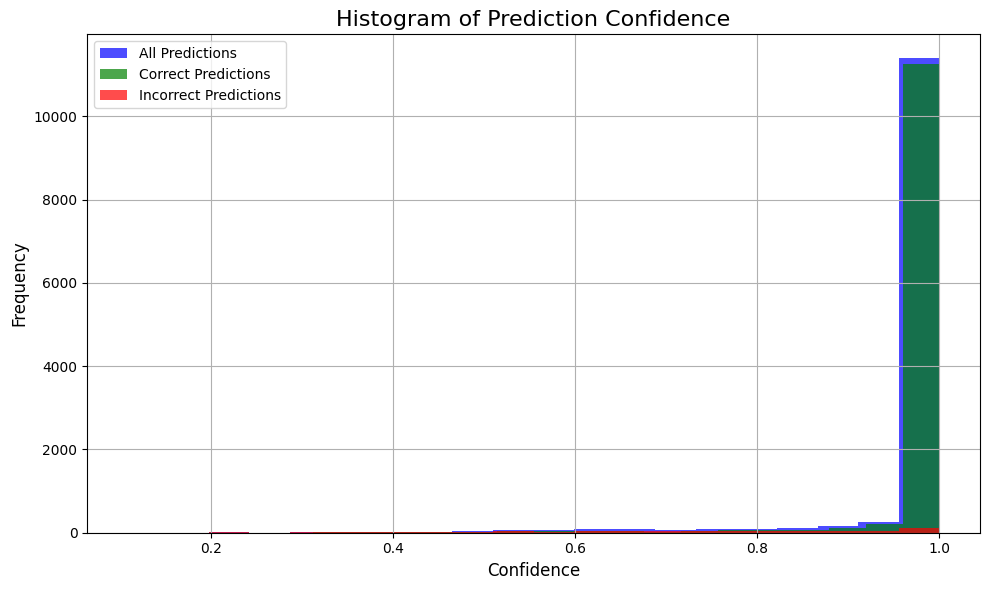

In [22]:
plot_prediction_confidence(model, test_loader, device, num_bins=20)

In [23]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(model, test_loader, device, num_bins=10):
    """
    Plot a calibration curve to evaluate the reliability of the model's confidence scores.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to perform testing on (CPU or GPU).
        num_bins (int): Number of bins for calibration.
    """
    model.eval()
    all_labels = []
    all_confidences = []
    all_predictions = []

    # Collect predictions and confidences
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Calculating Calibration Data"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_confidence, predicted = probabilities.max(1)

            all_confidences.extend(max_confidence.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Binarize the predictions for calibration_curve
    true_labels = (np.array(all_labels) == np.array(all_predictions)).astype(int)
    confidences = np.array(all_confidences)

    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(true_labels, confidences, n_bins=num_bins, strategy='uniform')

    # Plot calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label="Calibration Curve", color="blue")
    plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration (Ideal)", color="gray")
    plt.title("Calibration Curve", fontsize=16)
    plt.xlabel("Mean Predicted Probability", fontsize=12)
    plt.ylabel("Fraction of Positives", fontsize=12)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Calculating Calibration Data: 100%|██████████| 12630/12630 [02:16<00:00, 92.28it/s] 
<ipython-input-23-035aff4a45d5>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration (Ideal)", color="gray")


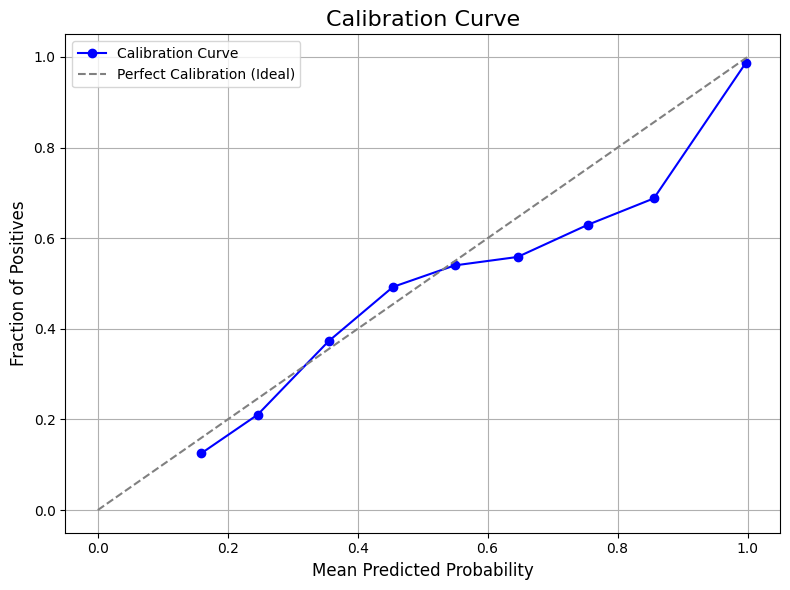

In [24]:
plot_calibration_curve(model, test_loader, device, num_bins=10)

In [25]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_classification_report(model, test_loader, device, class_names):
    """
    Visualize the classification report as a heatmap.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to perform testing on (CPU or GPU).
        class_names (list): List of class names corresponding to the dataset labels.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    # Collect predictions and true labels
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Calculating Classification Report Data"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Generate classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names, output_dict=True)

    # Convert to DataFrame for better visualization
    report_df = pd.DataFrame(report).transpose()

    # Plot heatmap
    plt.figure(figsize=(10, len(class_names) // 2))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f", cbar=False, linewidths=0.5)
    plt.title("Classification Report Heatmap", fontsize=16)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Classes", fontsize=12)
    plt.tight_layout()
    plt.show()


Calculating Classification Report Data: 100%|██████████| 12630/12630 [02:18<00:00, 91.04it/s] 


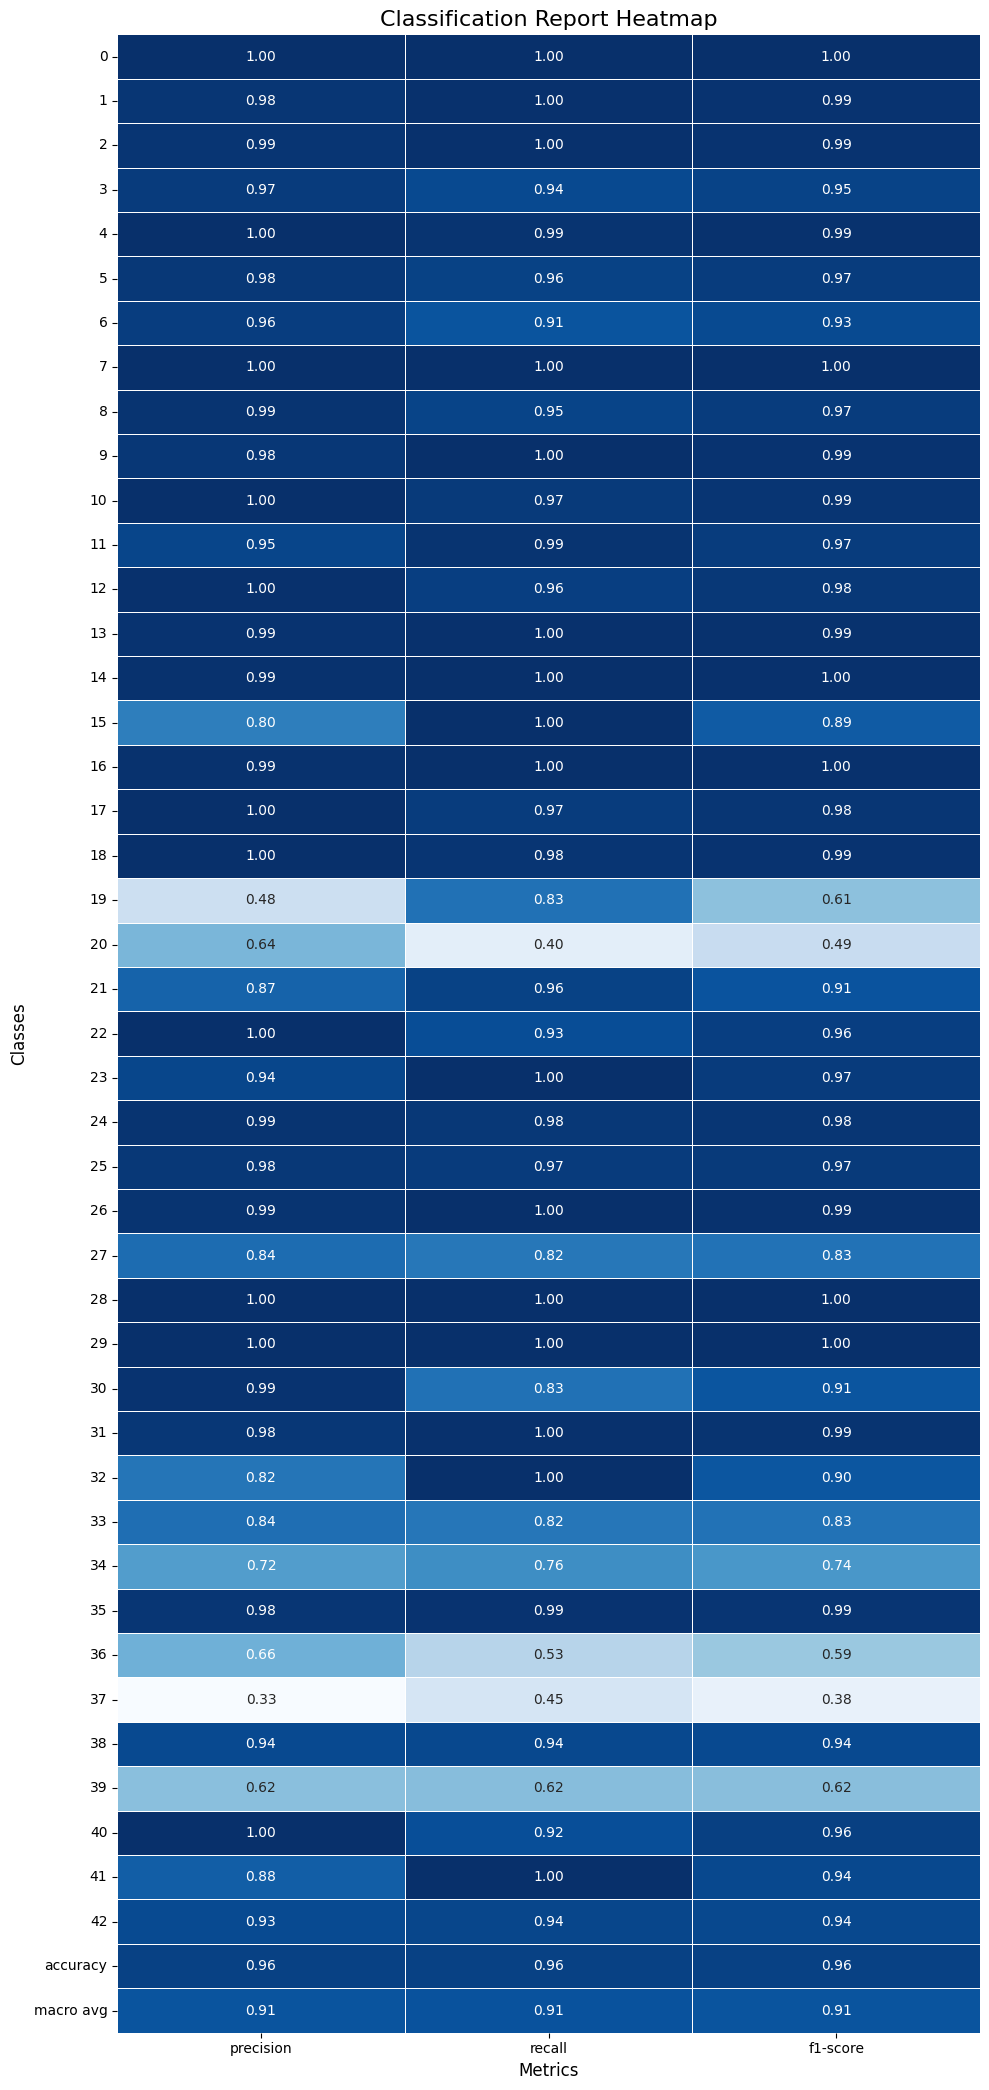

In [26]:
# Example class names (replace with your actual class names)
class_names = [str(i) for i in range(43)]

# Plot the classification report heatmap
plot_classification_report(model, test_loader, device, class_names)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_cumulative_gains(model, test_loader, device):
    """
    Plot a Cumulative Gains Chart.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to perform testing on (CPU or GPU).
    """
    model.eval()
    all_labels = []
    all_probabilities = []

    # Collect true labels and model probabilities
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Calculating Cumulative Gains Data"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    # Assuming binary classification (adjust for multi-class if necessary)
    positive_class = 1  # Define the positive class
    probabilities_positive = all_probabilities[:, positive_class]

    # Sort probabilities and labels together
    sorted_indices = np.argsort(probabilities_positive)[::-1]
    sorted_labels = all_labels[sorted_indices]

    # Calculate cumulative gains
    total_positives = np.sum(sorted_labels == positive_class)
    cumulative_positives = np.cumsum(sorted_labels == positive_class)
    percentage_of_data = np.arange(1, len(sorted_labels) + 1) / len(sorted_labels)
    percentage_of_positives = cumulative_positives / total_positives

    # Plot cumulative gains
    plt.figure(figsize=(8, 6))
    plt.plot(percentage_of_data, percentage_of_positives, label="Model", color="blue")
    plt.plot([0, 1], [0, 1], 'k--', label="Random", color="gray")
    plt.title("Cumulative Gains Chart", fontsize=16)
    plt.xlabel("Percentage of Data", fontsize=12)
    plt.ylabel("Percentage of Positives", fontsize=12)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Calculating Cumulative Gains Data: 100%|██████████| 12630/12630 [02:16<00:00, 92.73it/s] 
<ipython-input-27-25354360c501>:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label="Random", color="gray")


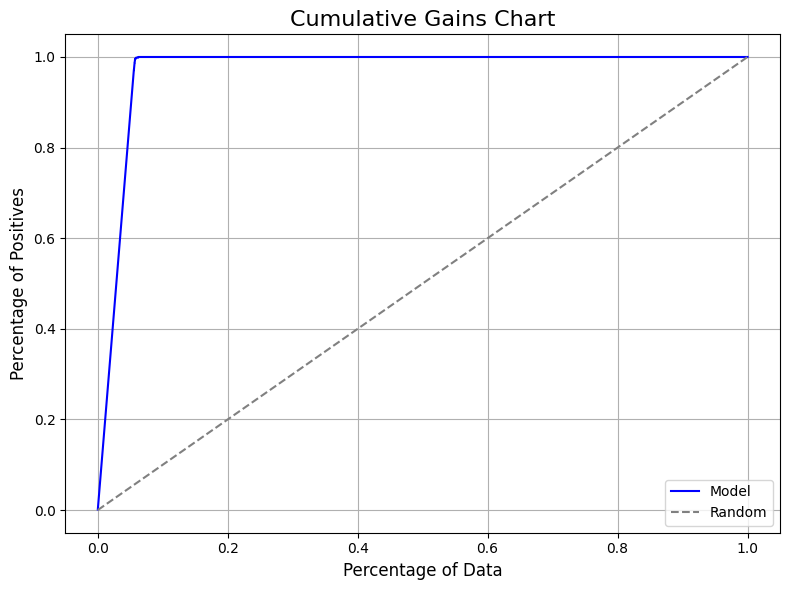

In [28]:
plot_cumulative_gains(model, test_loader, device)

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lift_curve(model, test_loader, device):
    """
    Plot a Lift Curve.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to perform testing on (CPU or GPU).
    """
    model.eval()
    all_labels = []
    all_probabilities = []

    # Collect true labels and model probabilities
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Calculating Lift Curve Data"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    # Assuming binary classification (adjust for multi-class if necessary)
    positive_class = 1  # Define the positive class
    probabilities_positive = all_probabilities[:, positive_class]

    # Sort probabilities and labels together
    sorted_indices = np.argsort(probabilities_positive)[::-1]
    sorted_labels = all_labels[sorted_indices]

    # Calculate cumulative gains
    total_positives = np.sum(sorted_labels == positive_class)
    cumulative_positives = np.cumsum(sorted_labels == positive_class)
    percentage_of_data = np.arange(1, len(sorted_labels) + 1) / len(sorted_labels)
    lift = cumulative_positives / (percentage_of_data * total_positives)

    # Plot lift curve
    plt.figure(figsize=(8, 6))
    plt.plot(percentage_of_data, lift, label="Model", color="blue")
    plt.axhline(1, color='gray', linestyle='--', label="Baseline (Random)")
    plt.title("Lift Curve", fontsize=16)
    plt.xlabel("Percentage of Data", fontsize=12)
    plt.ylabel("Lift", fontsize=12)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Calculating Lift Curve Data: 100%|██████████| 12630/12630 [02:16<00:00, 92.42it/s] 


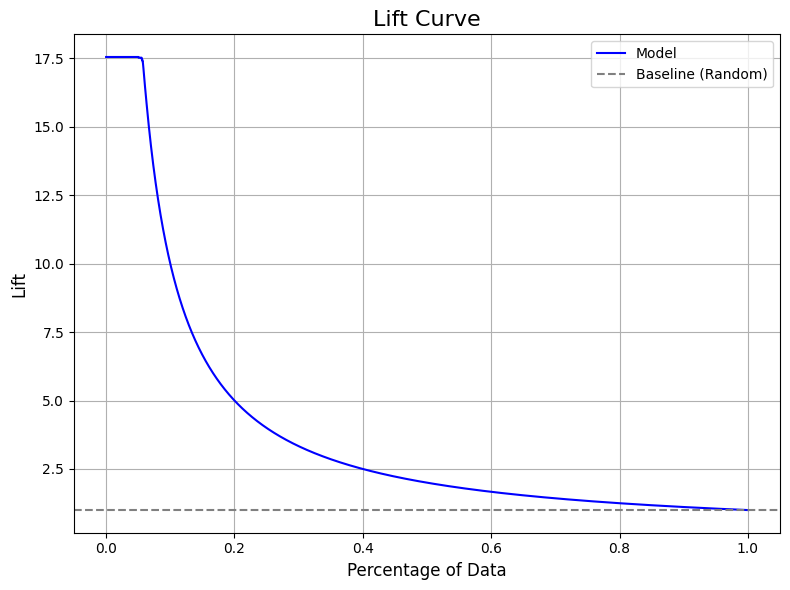

In [30]:
plot_lift_curve(model, test_loader, device)